In [1]:
# the fast.ai library
from fastai import *
from fastai.vision import *
from PIL import Image
import os 
from pathlib import Path

In [2]:
INPUT = Path("./input/digit-recognizer")

In [3]:
os.listdir(INPUT)

['train.csv', 'sample_submission.csv', 'test.csv']

In [4]:
train_df = pd.read_csv(INPUT/"train.csv")
train_df.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test_df =  pd.read_csv(INPUT/"test.csv")
test_df.head(3)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
TRAIN = Path("./train")
TEST = Path("./test")

In [7]:
# Create training directory
for index in range(10):
    try:
        os.makedirs(TRAIN/str(index))
    except:
        pass

In [8]:
sorted(os.listdir(TRAIN))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [9]:
# create the test directory 
try: 
    os.makedirs(TEST)
except:
    pass


In [10]:
# transforms
tfms = get_transforms(do_flip=False, max_zoom=1.2)

In [11]:
data = ImageDataBunch.from_folder(
    path = ".",
    train = 'train',
    test = "test",
    valid_pct = 0.2,
    bs = 32,
    size = 28,
    ds_tfms = tfms,
    #num_workers = 0
)

In [12]:
data.normalize(mnist_stats)

ImageDataBunch;

Train: LabelList (33602 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
6,6,6,6,6
Path: .;

Valid: LabelList (8400 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
8,7,7,2,5
Path: .;

Test: LabelList (28000 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: EmptyLabelList
,,,,
Path: .

In [13]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy, model_dir="/tmp/models", callback_fns=ShowGraph)

In [14]:
data.classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'img']

epoch,train_loss,valid_loss,accuracy,time
0,1.350873,0.905425,0.718214,00:23
1,1.119497,0.685003,0.789524,00:22
2,0.885953,0.574042,0.817381,00:22
3,0.705096,0.462219,0.858333,00:22
4,0.562042,0.366468,0.879762,00:22
5,0.472741,0.262063,0.921191,00:22
6,0.401865,0.235198,0.925714,00:22
7,0.316506,0.157297,0.952738,00:22
8,0.257687,0.123419,0.962857,00:22
9,0.209499,0.101630,0.967619,00:22


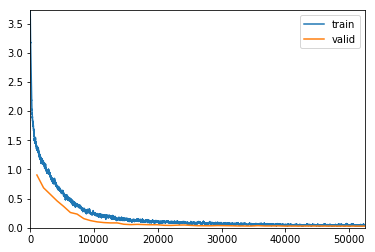

In [15]:
learn.fit_one_cycle(cyc_len=50)

In [16]:
interp = ClassificationInterpretation.from_learner(learn)

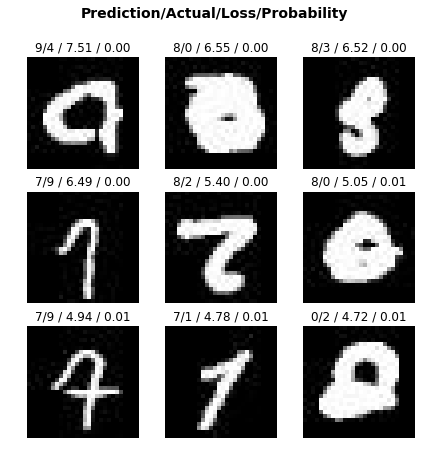

In [17]:
interp.plot_top_losses(9, figsize=(7, 7))

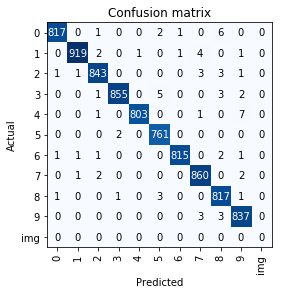

In [18]:
interp.plot_confusion_matrix()

In [19]:
class_score, y = learn.get_preds(DatasetType.Test)

In [20]:
class_score

tensor([[2.6878e-08, 1.4714e-06, 1.0000e+00,  ..., 2.4160e-08, 7.0917e-10,
         3.1960e-10],
        [9.9997e-01, 4.2916e-08, 1.1564e-05,  ..., 2.0424e-06, 1.0924e-05,
         3.2805e-09],
        [1.0739e-11, 2.4714e-11, 4.5309e-11,  ..., 1.0976e-08, 4.7840e-08,
         1.8341e-11],
        ...,
        [3.9778e-10, 2.3017e-10, 4.8583e-08,  ..., 9.5006e-07, 7.9854e-09,
         3.5030e-11],
        [1.0432e-04, 2.6408e-04, 4.5156e-06,  ..., 1.1132e-03, 1.9185e-03,
         3.4816e-08],
        [1.0363e-05, 9.9996e-01, 3.4132e-06,  ..., 3.1564e-07, 2.4912e-06,
         8.1431e-09]])

In [21]:
class_score.shape

torch.Size([28000, 11])

In [22]:
y

tensor([0, 0, 0,  ..., 0, 0, 0])

In [23]:
predictions = np.argmax(class_score, axis=1)
# convert to list 
predictions = predictions.tolist()

In [24]:
len(predictions)

28000

In [25]:
# remove file extension from filename
ImageID = [os.path.splitext(path)[0] for path in os.listdir(TEST)]
# typecast to int so that file can be sorted by ImageId
ImageID = [int(id) for id in ImageID]
# +1 because index starts at 1 in the submission file
ImageID = [id+1 for id in ImageID]

In [26]:
len(ImageID)

28000

In [27]:
submission  = pd.DataFrame({
    "ImageId": ImageID,
    "Label": predictions
})

In [28]:
# submission.sort_values(by=["ImageId"], inplace = True)
submission.to_csv("./submission.csv", index=False)
display(submission.head(3))
display(submission.tail(3))

,ImageId,Label
0,14308,2
1,17921,0
2,21118,5


,ImageId,Label
27997,4056,3
27998,5958,6
27999,17349,1
